<a href="https://colab.research.google.com/github/machlovi/Spock-paper/blob/main/X_hate_and_offensive_data_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect with Gdrive

In [ ]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
# %cd /gdrive

Mounted at /gdrive


# Import Libraries

In [ ]:
import os
import random
import pickle
from timeit import default_timer as timer
from tqdm import tqdm, trange

import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

!pip install transformers --quiet
from transformers import TFAutoModel, BertTokenizerFast, BertModel
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.constraints import MaxNorm
import keras
from keras.layers import Input, Concatenate, Flatten, Embedding, Dense, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Lambda

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.3 MB/s eta 0:00:00


#Data import

Data Source "https://github.com/t-davidson/33 ##
hate-speech-and-offensive-language/blob/master/data/readme.md"
'''hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither'''



### Hate and offesive data

In [ ]:
df_data1=pd.read_csv("/gdrive/MyDrive/SPOCK/Dataset/hate-speech-and-offensive-language-master/data/labeled_data.csv")


df_peace=df_data1[df_data1['class']==2]
df_peace=df_peace[['class','tweet']].reset_index(drop=True)
df_hate=df_data1[(df_data1['class']==0) | (df_data1['class']==1)]

df_hate=df_data1[(df_data1['class']==0) | (df_data1['class']==1)]
df_hate=df_hate[['class','tweet']].reset_index(drop=True)
df_hate['class']=1
df_peace['class']=0




In [ ]:
df_peace['class'].unique()

NameError: ignored

### Xhate data set
Class 1 hate, Class 0 non-hate speech

In [ ]:
# @title
# # Use this part for single file
# # Define the path to your text file
# file_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train/XHate999-EN-Gao-train.txt"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Read the file line by line
# with open(file_path, 'r') as file:
#     for line in file:
#         # Split the line into text and label using the last character
#         line = line.strip()  # Remove leading/trailing whitespace
#         text = line[:-2].strip()  # Extract text (excluding the last character)
#         label = line[-1]  # Extract the label (as an integer)

#         # Append data to lists
#         tweets.append(text)
#         labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'Text': tweets, 'Label': labels})
# df.drop(0,inplace=True)

# # Display the DataFrame
# print(df)


In [ ]:
import os
import glob

# Define the directory path where your text files are located
directory_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train"

# Initialize empty lists to store data
tweets = []
labels = []

# Loop through all text files in the specified directory
for filename in glob.glob(os.path.join(directory_path, '*.txt')):
    with open(filename, 'r') as file:

      for line in file:
          # Split the line into text and label using the last character
          line = line.strip()  # Remove leading/trailing whitespace
          text = line[:-2].strip()  # Extract text (excluding the last character)
          label = line[-1]  # Extract the label (as an integer)

          # Append data to lists
          tweets.append(text)
          labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'tweet': tweets, 'class': labels})
df.drop(0,inplace=True)


df['class']=pd.to_numeric(df['class'], errors='coerce')
df['class'].fillna(0, inplace=True)
df['class']=df['class'].astype(int)
df_hate2=df[df['class']==1]
df_nonhate2=df[df['class']==0]

##Combing hatespeech and xhate data for hate/offensive class

In [ ]:
def text_preprocessing(text,                                                               # text is a word string ex. 'rahul in ny'
                      punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~='ã¶``''',
                      stop_words = set(stopwords.words("english"))) -> list:

        '''
        A method to preprocess text

        '''

        for x in text.lower():
            if x in punctuations:
                text = text.replace(x,"")

        # removing words that have numbers in them
        text = re.sub(r'\w*\d\w*', '', text)
        # remove digits
        text = re.sub(r'[0-9]+', ' ', text)

        # clean the whitespaces

        text = re.sub(r'\s+', ' ', text).strip()



        # convert all text to a list

        # text = text.split(' ').  # uncomment if list required
        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text) # no emoji

        # lowercase eth

        text = text.lower()


        # drop the stop words



        # add the tags

        return text

In [ ]:
df_hate_combine=pd.concat([df_hate,df_hate2]).reset_index(drop=True)
df_nonhat_combine=pd.concat([df_peace,df_nonhate2]).reset_index(drop=True)

In [ ]:
df_hate_combine["tweet"] = df_hate_combine["tweet"].apply(lambda x : text_preprocessing(x))
df_nonhat_combine["tweet"] = df_nonhat_combine["tweet"].apply(lambda x : text_preprocessing(x))

In [ ]:
dataframe=pd.concat([df_hate_combine ,df_nonhat_combine]).reset_index(drop=True)
dataframe.dropna(inplace=True)


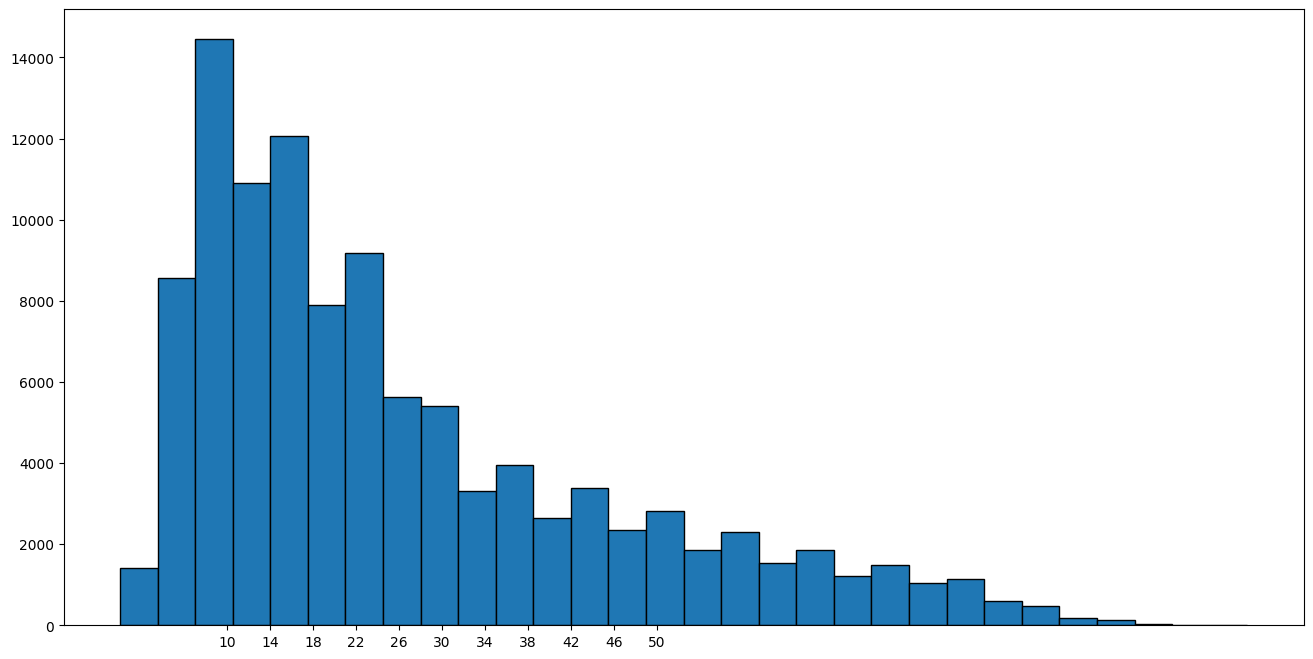

In [ ]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["tweet"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,50,11))
plt.show()

In [ ]:
# dataframe[dataframe['class']==1].shape,dataframe[dataframe['class']==0].shape,dataframe[dataframe['class']==2].shape

# Training and validation set
We can also consider token length

In [ ]:
# token_length 128, seems a good fit for data

# split training and validation data
train_df, temp_df = train_test_split(dataframe, test_size= 0.30, stratify= dataframe["class"], random_state = 47)

val_df,   test_df   = train_test_split(temp_df, test_size= 0.50, stratify= temp_df["class"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
test_df  = test_df.reset_index(drop = True)

In [ ]:
dataframe["token_length"] = token_lengths
dataframe = dataframe.loc[dataframe["token_length"] <= 45, :].reset_index(drop=True)

#Bert Model

In [ ]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# dataset generator (for input to tf.data.Dataset.from_generator())

class dataset:

  def __init__(self,text,labels,max_length, tokenizer,projection_dim, val = False):

    self.text =   text
    self.labels = labels
    self.max_length = max_length
    self.tokenizer = tokenizer
    self.flag = val
    self.projection_dim = projection_dim

  def __len__(self):

    return  self.text.shape[0]

  def __getitem__(self,index):

    sentence = self.text[index]
    category = self.labels[index]

    return sentence, category


  # shuffle the dataset after each epoch
  def on_epoch_end(self):

    random_idx = random.sample(list(range(self.__len__())), k = self.__len__())
    self.text   = self.text[random_idx]
    self.labels = self.labels[random_idx]

  def __call__(self):

    for i in range(self.__len__()):
      sentence, label = self.__getitem__(i)
      encodings = self.tokenizer(sentence,
                                 max_length = self.max_length,
                                 padding = "max_length",
                                 truncation = True)

      input_ids  = np.array(encodings["input_ids"])
      masks      = np.array(encodings["attention_mask"])
      ttids      = np.array(encodings["token_type_ids"])

      embedding_index = np.array([i for i in range(self.projection_dim)])
      embedding_index = np.ravel(embedding_index)

      embedding_index = np.tile(embedding_index, (input_ids[0:1].shape[0],))

      yield {"input_ids": input_ids, "attention_masks": masks,"space": embedding_index}, label

      # randomize the dataset on epoch end, only in case of training dataset
      if i == self.__len__() -1 and self.flag is False:
        self.on_epoch_end()

#Paramters

In [ ]:
MAX_LENGTH = 45
BATCH_SIZE = 32
PROJECTION_DIM = 10
VECTOR_DIM = 768

In [ ]:
# create generators for train and validation
train_gen = dataset(train_df["tweet"].values,train_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)
val_gen   = dataset(val_df["tweet"].values,val_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)

In [ ]:
train_gen[1000]

('if you absorb light from all sides is there no limit to the speed you can go after all there is no light to clock you robert claypool',
 0)

In [ ]:
# create tensorflow dataloaders from generators

train_ds = tf.data.Dataset.from_generator(train_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).repeat().batch(batch_size = BATCH_SIZE) # shuffling is already implemented in dataset class

val_ds = tf.data.Dataset.from_generator(val_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
## AUXILLIARY FUNCTIONS

In [ ]:
# NA
def return_embedding_index(x_train,count):

  embedding_index=np.array([i for i in range(count)])

  embeding_index=np.ravel(embedding_index) # flattens the array

  rank = len(x_train.shape)
  if rank < 3:
    embedding_index = np.tile(embedding_index,(x_train[0:1].shape[0],1,))
  else:
    embedding_index = np.tile(embedding_index,(x_train.shape[0],1,))

  return embedding_index


# cosine similarity b/w two vectors
def cosine_similarity_projected(vects):

  x,w=vects

  dp = tf.matmul(x, w)


  x_mag = tf.norm(x, axis=2, keepdims = True)

  w_mag = tf.norm(w,axis = 1, keepdims = True)

  denominator = dp / x_mag
  cosine = denominator / w_mag

  return cosine

# NA
def compare_cosine(vector):

  peace,violent=vector

  peace=tf.math.reduce_mean(peace, axis=1)
  violent=tf.math.reduce_mean(violent, axis=1)
  out=tf.concat([peace,violent],axis=-1)
  print("COMPARE-COSINE")
  print('out.shape')
  print(out.shape)


  return out

# NA
# takes mean embeddings
class remove_pads(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_pads,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)



  def call(self,listInputs):

    inputs = listInputs[0]
    input_ids = listInputs[1]
    masks = self.mask_generator.compute_mask(input_ids)
    masks = tf.cast(masks,tf.float32)
    masks = tf.expand_dims(masks,axis=-1)
    temp = tf.unstack(masks,axis=1)
    del temp[0]
    temp.insert(0,tf.zeros_like(temp[0]))
    masks = tf.stack(temp,axis=1)
    length = tf.math.reduce_sum(masks,axis = 1, keepdims=True)     # (None,1,1)
    # mask the embeddings corresponding to zero input id ==0
    masked_embeddings = inputs * masks    # (None,64,300) * (None,64,1) = (None,64,300)
    # take SUM, (not mean)
    masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True)
    # now just divide each by the length to get mean of non zero embeddings
    masked_embeddings = masked_embeddings / length

    return masked_embeddings



class remove_padsV2(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_padsV2,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words



  def call(self,listInputs):

    inputs = listInputs[0]                   # (None,MAX_LENGTH,PROJECTION_DIM)
    input_ids = listInputs[1]                # (None,MAX_LENGTH)

    # convert token ids 101 and 102 to 0
    filteredInputIds = tf.where(tf.equal(input_ids,101) | tf.equal(input_ids,102),0,input_ids)
    # get masks for input ids
    masks = self.mask_generator.compute_mask(filteredInputIds)
    masks = tf.cast(masks,tf.float32)
    masks = tf.expand_dims(masks,axis=-1)    # (None,MAX_LENGTH,1)

    masked_embeddings = inputs * masks

    return masked_embeddings



# mean embeddings
def merge_function(vects):

  positive, negative = vects[0], vects[1]    # (None,MAX_LENGTH,PROJECTION_DIM)


  # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0
  # we sum them up and then divide with number of non-zeros to get average cosine similarities
  positiveLength = tf.math.count_nonzero(tf.math.reduce_sum(positive, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)   # (None,1,1)
  negativeLength = tf.math.count_nonzero(tf.math.reduce_sum(negative, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)

  # now obtain average of cosine similarities
  positive = tf.math.reduce_sum(positive,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
  positiveAverage = tf.divide(positive, positiveLength)

  negative = tf.math.reduce_sum(negative,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
  negativeAverage = tf.divide(negative, negativeLength)



  # input_shape = (None,1,Projection_DIM)
  res = tf.concat([positiveAverage,negativeAverage], axis = -1)    # (None,1,PROJECTION_DIM)

  return res


# max embeddings
def merge_functionV2(vects):

  positive, negative = vects[0], vects[1]
  # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0


  # TAKE MAXIMUM COSINE SIMILARITY OF ALL THE TOKENS OF A SENTENCE WRT EACH PROJECTION DIM
  positiveMax = tf.reduce_max(positive, axis=1, keepdims=True)     # (None, 1, PROJECTION_DIM)
  negativeMax = tf.reduce_max(negative, axis=1, keepdims=True)


  res = tf.concat([positiveMax,negativeMax], axis = -1)            # (None,1,  2 * PROJECTION_DIM)

  return res

Loading Weights

In [ ]:
with open('/gdrive/MyDrive/SPOCK/Dataset/nweights.npy', 'rb') as f:
    hate_weights = np.load(f,allow_pickle=True)
hate_weights=np.reshape(hate_weights,[1,np.shape(hate_weights)[0],np.shape(hate_weights)[1]])
PROJECTION_DIM=hate_weights.shape[1]

In [ ]:
# Model Debugging - Rahul
DEBUG = "DEBUG"

# for input we have
# 1. input ids
# 2. attention_masks
# 3. embedding_index (PROJECTION_DIM)
# 4. label

# first two will go to bert as input
ids = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "input_ids")
mks = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "attention_masks")
projection_space = layers.Input(name = "space", shape = (PROJECTION_DIM,))


input_sentence = bertModel(ids, attention_mask = mks)[0]                        # layers freezed, last_hidden_state_output


positive_embedding_layer =  layers.Embedding(name = "positive_embedding",
                                   input_dim = PROJECTION_DIM,
                                   output_dim=VECTOR_DIM,
                                  #  embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
                                   input_length = PROJECTION_DIM ,
                                   weights=hate_weights,
                                   trainable=False,
                                   mask_zero=True)


negative_embedding_layer =  layers.Embedding(name = "negative_embedding",
                                   input_dim=PROJECTION_DIM,
                                   output_dim=VECTOR_DIM,
                                  #  embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
                                   input_length = PROJECTION_DIM ,
                                   weights=hate_weights,
                                   trainable=False,
                                   mask_zero=True)


# embeddings for projection space
positive_embedding_np = positive_embedding_layer(projection_space)              # (None,PROJECTION_DIM,VECTOR_DIM)
negative_embedding_np = negative_embedding_layer(projection_space)              # (None,PROJECTION_DIM,VECTOR_DIM)

#Permute
positive_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(positive_embedding_np)
negative_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(negative_embedding_np)


# pos_projection_space
positive_cosine = layers.Lambda(function=cosine_similarity_projected,
                      name='cosine_positive')([input_sentence, positive_embedding])              # (None,MAX_LENGTH,PROJECTION_DIM)


# neg_projection_space
negative_cosine = layers.Lambda(function=cosine_similarity_projected,
                         name='cosine_negative')([input_sentence, negative_embedding])



# remove paddings from cosines from both layers
positive_cosine_nopads = remove_padsV2(name="remove_cls_pad_positive")([positive_cosine, ids])   # (None,MAX_LENGTH,PROJECTION_DIM)
negative_cosine_nopads = remove_padsV2(name="remove_cls_pad_negative")([negative_cosine, ids])



# merge (v1: mean, v2: max)
merged = layers.Lambda(function=merge_functionV2,
                name='TakeMaxCosineAndCompare')([positive_cosine_nopads, negative_cosine_nopads])  # (None,1,1002)    # !these values are not really identical beacause both embedding layers had different random weights

merged = layers.Flatten(data_format = "channels_first")(merged)

# CLASSIFICATION HEAD

hidden = layers.Dense(256, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(merged)

hidden = layers.Dropout(0.25, name="drop-1")(hidden)
hidden = layers.Dense(64, activation='relu', name = "hidden-2", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-2")(hidden)
hidden = layers.Dense(16, activation='relu', name = "hidden-3", kernel_constraint=MaxNorm(3),
               kernel_initializer= "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-3")(hidden)


predictions = layers.Dense(1, activation= "sigmoid" , name='classification_layer')(hidden)

model = Model(inputs=[ids, mks, projection_space],outputs= predictions)

In [ ]:
# model.summary()


Loss Function

In [ ]:
# reduce similarity among projection spaces
projection_loss = tf.keras.losses.CosineSimilarity()(tf.math.reduce_mean(positive_cosine, axis=1), tf.math.reduce_mean(negative_cosine, axis=1))
model.add_loss((1.0/(1.01 + projection_loss)))


# increase stdDevLoss in projection dimension
def StdDevLoss(x):                                                              # (None,MAX_LEN,PROJECTION_DIM)

  stdDev = tf.math.reduce_std(x,axis=2)                                         # (None,MAX_LEN)
  stdDevLoss = tf.math.reduce_mean(stdDev)

  return stdDevLoss


posStdDevLoss = StdDevLoss(positive_cosine)
negStdDevLoss = StdDevLoss(negative_cosine)

# model.add_loss(1.0 / (posStdDevLoss + 0.001))
# model.add_loss(1.0 / (negStdDevLoss + 0.001))

model.add_loss(-1 * posStdDevLoss)
model.add_loss(-1 * negStdDevLoss)

# cross entropy loss
crossEntropLoss = tf.keras.losses.BinaryCrossentropy(from_logits = False)


# optimize can compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, clipnorm = 1.0)
model.compile(loss = crossEntropLoss , optimizer = optimizer, metrics=["accuracy"])

In [ ]:
# mini batches per epoch
len(train_gen) // BATCH_SIZE

2358

In [ ]:
# BASE_PATH = "/gdrive/Shareddrives/Thesis/"
BASE_PATH = "/gdrive/MyDrive/SPOCK/Dataset/Model"

In [ ]:
# uncomment while training:

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= BASE_PATH + "test1.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto",
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True)

In [ ]:
train_ds

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 45), dtype=tf.int32, name=None), 'attention_masks': TensorSpec(shape=(None, 45), dtype=tf.int32, name=None), 'space': TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
EPOCHS = 1
history = model.fit(
    train_ds,
    steps_per_epoch = len(train_gen) // BATCH_SIZE,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = [modelcheckpoint]
)

  59/2358 [..............................] - ETA: 4:32:40 - loss: 1.3020 - accuracy: 0.6578

KeyboardInterrupt: ignored

In [ ]:
dataframe

,class,tweet,token_length
0,1,rt boy dats coldtyga dwn bad for cuffin dat ho...,13
1,1,rt urkindofbrand dawg rt you ever fuck a bitch...,19
2,1,rt cganderson vivabased she look like a tranny,8
3,1,rt shenikaroberts the shit you hear about me m...,24
4,1,tmadisonx the shit just blows meclaim you so f...,18
...,...,...,...
88765,0,according to wikipedia guidelines it is correc...,14
88766,0,please continue the discussion at,5
88767,0,youll find all sources state that he has not m...,24
88768,0,pictures came in hi rick i got the recent pics...,18


In [ ]:
BATCH_SIZE

32

In [ ]:
offensive=['slave','ugly', 'useless', 'racist', 'immigrants', 'harassment','stupid',
           'fool', 'terrorist', 'communists', 'hell','gay', 'dick','hell', 'gay', 'dick', 'nazis',
           'screw', 'fascist']

In [ ]:
lexicons=pd.read_csv('/gdrive/MyDrive/SPOCK/Dataset/hate-speech-and-offensive-language-master/lexicons/refined_ngram_dict.csv')

In [ ]:
df=pd.DataFrame({'ngram':offensive})
df

,ngram
0,slave
1,ugly
2,useless
3,racist
4,immigrants
5,harassment
6,stupid
7,fool
8,terrorist
9,communists


In [ ]:
pd.concat([lexicons[['ngram']],df],axis=0)

,ngram
0,allah akbar
1,blacks
2,chink
3,chinks
4,dykes
...,...
14,gay
15,dick
16,nazis
17,screw


,ngram
0,allah akbar
1,blacks
2,chink
3,chinks
4,dykes
...,...
173,nigga you a lame
174,niggers are in my
175,wit a lame nigga
176,you a lame bitch
